In [1]:
import time
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## GPU info

In [2]:
print(f'CUDA avail: {torch.cuda.is_available()}')
print(f'PyTorch version: {torch.__version__}')
print('*'*10)

print(f'_CUDA version: ')
!nvcc --version
print('*'*10)

print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'GPU ID: {torch.cuda.current_device()}')
print(f'Device Name: {torch.cuda.get_device_name(0)}')
print('*'*10)

device = torch.device("cuda")
total_memory_gb = torch.cuda.get_device_properties(device).total_memory / 1024**3
print(f"GPU memory: {round(total_memory_gb,3)} GB")

#currently being used by a process
print(f"GPU memory alocated:{torch.cuda.memory_allocated()} Bytes")
#GPU memory that is allocated to a process but is not yet being used
print(f"GPU memory cached:{torch.cuda.memory_reserved()} Bytes")

CUDA avail: True
PyTorch version: 2.0.1
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Fri_Dec_17_18:28:54_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.6, V11.6.55
Build cuda_11.6.r11.6/compiler.30794723_0
**********
CUDNN version: 8500
Available GPU devices: 1
GPU ID: 0
Device Name: NVIDIA GeForce GTX 1660 Ti
**********
GPU memory: 6.0 GB
GPU memory alocated:0 Bytes
GPU memory cached:0 Bytes


## Define NN Class

In [3]:
class Model(nn.Module):
    def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
        # intput 4 features --> h1 8 neuron--> h2 9 neuron--> output 3 class
        
        super().__init__() #init nn.Module's init method
        
        self.fc1 = nn.Linear(in_features,h1)    # input layer, fully connected
        self.fc2 = nn.Linear(h1, h2)            # hidden layer, fully connected
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x)) #fc1 --> relu
        x = F.relu(self.fc2(x)) #fc2 --> relu
        x = self.out(x) #output of nn
        return x

## Preview data

In [4]:
df = pd.read_csv('../Data/iris.csv')
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [5]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,1.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


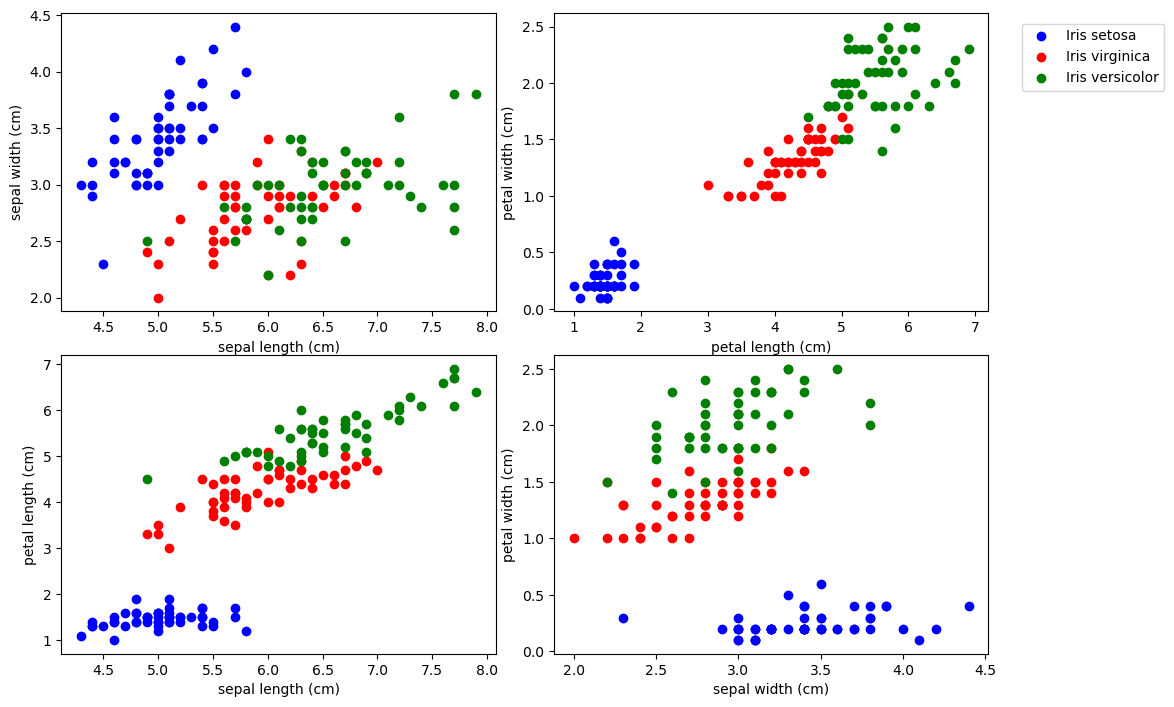

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

## Split

In [7]:
X = df.drop('target',axis=1).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train = torch.FloatTensor(X_train).cuda()
X_test = torch.FloatTensor(X_test).cuda()

y_train = torch.LongTensor(y_train).cuda() #dont need float
y_test = torch.LongTensor(y_test).cuda()

In [8]:
print(X_train[:5],"\n")
print(y_train[:5],"\n")
print(X_test[:5],"\n")
print(y_test[:5],"\n")

tensor([[4.6000, 3.6000, 1.0000, 0.2000],
        [5.7000, 4.4000, 1.5000, 0.4000],
        [6.7000, 3.1000, 4.4000, 1.4000],
        [4.8000, 3.4000, 1.6000, 0.2000],
        [4.4000, 3.2000, 1.3000, 0.2000]], device='cuda:0') 

tensor([0, 0, 1, 0, 0], device='cuda:0') 

tensor([[6.1000, 2.8000, 4.7000, 1.2000],
        [5.7000, 3.8000, 1.7000, 0.3000],
        [7.7000, 2.6000, 6.9000, 2.3000],
        [6.0000, 2.9000, 4.5000, 1.5000],
        [6.8000, 2.8000, 4.8000, 1.4000]], device='cuda:0') 

tensor([1, 0, 2, 1, 1], device='cuda:0') 



## Train

In [9]:
trainloader = DataLoader(X_train, batch_size=60, shuffle=True)
testloader = DataLoader(X_test, batch_size=60, shuffle=False)

In [10]:
# Instantiate the Model class using parameter defaults:
torch.manual_seed(42)
model = Model().cuda()

In [11]:
criterion = nn.CrossEntropyLoss() #no need one hot encoding fr CEL
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [12]:
start_time = time.time()

epochs = 200
losses = []

for i in range(epochs):
    
    i+=1
    
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    #save screen space:
    if i%10 == 0:
        print(f'epoch: {i:2}  loss: {loss.item():5.4f}') #width 4, rounded to 4deci

    optimizer.zero_grad() #find where grad 0
    loss.backward() #back grad
    optimizer.step() #take a step
    
    
end_time = time.time()
execution_time = end_time - start_time   
print(f"\n Execution Time: {execution_time:.3f}s")

epoch: 10  loss: 0.9335
epoch: 20  loss: 0.7770
epoch: 30  loss: 0.6409
epoch: 40  loss: 0.4851
epoch: 50  loss: 0.3033
epoch: 60  loss: 0.1764
epoch: 70  loss: 0.1101
epoch: 80  loss: 0.0819
epoch: 90  loss: 0.0702
epoch: 100  loss: 0.0647
epoch: 110  loss: 0.0618
epoch: 120  loss: 0.0599
epoch: 130  loss: 0.0586
epoch: 140  loss: 0.0576
epoch: 150  loss: 0.0568
epoch: 160  loss: 0.0561
epoch: 170  loss: 0.0556
epoch: 180  loss: 0.0550
epoch: 190  loss: 0.0546
epoch: 200  loss: 0.0542

 Execution Time: 0.950s


Text(0.5, 0, 'epoch')

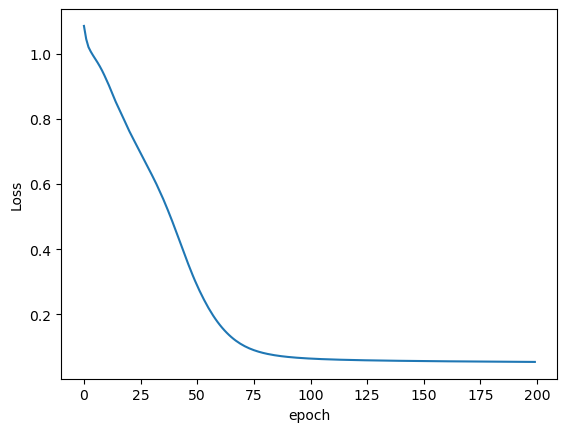

In [13]:
plt.plot(range(epochs), [loss.item() for loss in losses])
plt.ylabel('Loss')
plt.xlabel('epoch')

100 epoch is more than enough

In [14]:
# Empty GPU memory
for i in range(5):
    torch.cuda.empty_cache()
    gc.collect()

## Validation and performance

In [15]:
# turn of grad calculation for prediction
with torch.no_grad():
    y_test_pred = model.forward(X_test)
    loss = criterion(y_test_pred, y_test)
print(f'{loss:.4f}')

0.0404


loss better than training! :)
   

In [16]:
y_test_pred[:5]

tensor([[ -1.4487,   8.2862,   2.5930],
        [ 10.7691,   3.3258,  -9.8749],
        [-15.3115,   0.7401,  17.7596],
        [ -2.0505,   7.5603,   3.2402],
        [ -1.9362,   8.5947,   3.1609]], device='cuda:0')

In [17]:
# Get the predicted class labels
_, predicted_labels = torch.max(y_test_pred, 1)

# Convert the predicted labels to a numpy array
predicted_labels = predicted_labels.cpu().numpy()
predicted_labels[:20]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2],
      dtype=int64)

In [18]:
y_test_np = y_test.cpu().numpy()
y_test_np[:20]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2],
      dtype=int64)

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Calculate the accuracy
accuracy = accuracy_score(y_test_np, predicted_labels)
print(f"Accuracy: {accuracy*100}%", )

Accuracy: 100.0%


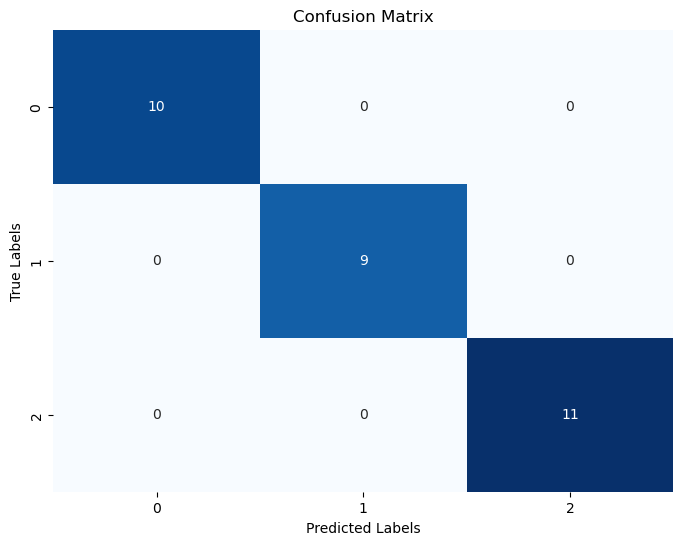

In [20]:
import numpy as np
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test_np, predicted_labels)

# Get the class labels
classes = np.unique(np.concatenate((y_test_np, predicted_labels)))

# Create a labeled confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Saving, loading, predicting
### save as pickle if you wat to save entire model with the Class

In [21]:
#state_dict of model to disc
torch.save(model.state_dict(),'asher_the_flower.pt')

In [22]:
loaded_model = Model()
loaded_model.load_state_dict(torch.load('asher_the_flower.pt'))
loaded_model = loaded_model.cuda()
loaded_model

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)

In [23]:
# turn of grad calculation for prediction
with torch.no_grad():
    pred = loaded_model.forward(X_test)


In [24]:
# Get the predicted class labels
maximum, predicted_labels = torch.max(pred, 1)


In [25]:
maximum

tensor([ 8.2862, 10.7691, 17.7596,  7.5603,  8.5947,  9.9785,  7.8859,  8.7230,
         6.1214,  8.4674,  7.1988,  9.7001, 10.7251,  9.8745, 10.3830,  8.2898,
        12.4175,  8.3464,  7.5481, 12.3488,  9.3825,  6.4058,  9.4039, 11.7509,
         8.9813,  9.8685, 11.5078, 12.2977,  9.2895,  9.2816], device='cuda:0')

In [26]:
predicted_labels

tensor([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2,
        2, 2, 2, 2, 0, 0], device='cuda:0')

In [27]:
# Convert the predicted labels to a numpy array
predicted_labels = predicted_labels.cpu().numpy()
predicted_labels[:50]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0], dtype=int64)

### Single input pred

In [28]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,1.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [29]:
df.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')

In [31]:
ran_sepal_l = np.random.uniform(df['sepal length (cm)'].min(),df['sepal length (cm)'].max())
ran_sepal_w = np.random.uniform(df['sepal width (cm)'].min(),df['sepal width (cm)'].max())
ran_petal_l = np.random.uniform(df['petal length (cm)'].min(),df['petal length (cm)'].max())
ran_petal_w = np.random.uniform(df['petal width (cm)'].min(),df['petal width (cm)'].max())


mystery_iris = torch.tensor([ran_sepal_l,ran_sepal_w,ran_petal_l,ran_petal_w])

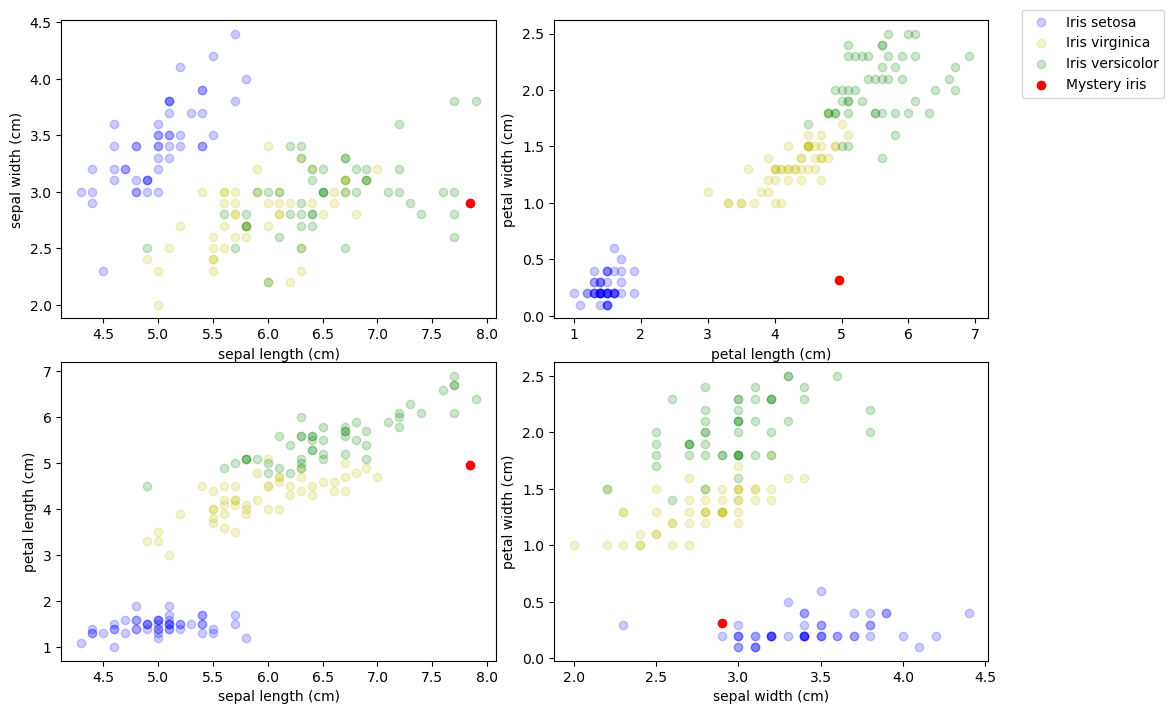

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'y', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor','Mystery iris']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j], alpha=0.2)
        ax.set(xlabel=x, ylabel=y)
        
    # Add a plot for our mystery iris:
    ax.scatter(mystery_iris[plots[i][0]],mystery_iris[plots[i][1]], color='r')
    
fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

In [33]:
# METHOD 1

with torch.no_grad():
    print(loaded_model(mystery_iris.cuda()))
    print()
    print(labels[loaded_model(mystery_iris.cuda()).argmax()])

tensor([ 2.8849, 10.1900, -1.7810], device='cuda:0')

Iris virginica


In [34]:
mystery_iris

tensor([7.8463, 2.9014, 4.9633, 0.3143])

In [35]:
mystery_iris.cuda()

tensor([7.8463, 2.9014, 4.9633, 0.3143], device='cuda:0')

In [36]:
X_test.size()

torch.Size([30, 4])

In [37]:
mystery_iris.cuda().reshape(-1,4).size()

torch.Size([1, 4])

In [38]:
# METHOD 2
with torch.no_grad():
    pred = loaded_model.forward(mystery_iris.cuda().reshape(-1,4))

# Get the predicted class labels
maximum, predicted_labels = torch.max(mystery_iris.cuda().reshape(-1,4), 1)

In [39]:
predicted_labels

tensor([0], device='cuda:0')

In [40]:
labels[predicted_labels]

'Iris setosa'